In [1795]:
from PIL import Image,ImageDraw
import random
import pandas as pd
import tensorflow as tf
import glob
import numpy as np
from math import pi
import random
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset generator

In [1793]:
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)

In [1759]:
def dataset_generator(imgs_num):
    rotated_images = []
    angles = []
    for _ in range(imgs_num):
        rectag_num = random.randint(1,10)
        random_angle = random.uniform(-10,10)
        img = Image.new('RGB', (128, 128), "white") #создание изображения 128*128
        lineDrawer = ImageDraw.Draw(img)
        drawing = ImageDraw.Draw(img)
        for _ in range(rectag_num):
            width = random.randint(1,5)
            x = random.uniform(0.1,1)*128
            y = random.uniform(0.1,1)*128
            #lineDrawer.rectangle(((x,y),(random.uniform(0,x-0.1*128),random.uniform(0,y-0.1*128))), outline = "black")
            drawing = ImageDraw.Draw(img)
            draw_rectangle(drawing,((x,y),(random.uniform(0.1*128,x-0.1*128),random.uniform(0.1*128,y-0.1*128))), color = "black",width=width)
        
        im2 = img.convert('RGBA')
        rotated = im2.rotate(random_angle, resample=Image.BICUBIC)
        fff = Image.new('RGBA', rotated.size)
        out = Image.composite(rotated, fff, rotated)
        out.convert('RGB')#img.mode
        rotated_images.append(out)
        angles.append(random_angle)
    yield  rotated_images,angles
        

In [1937]:
for (x,y) in dataset_generator(10000):
    x_train = x
    y_train = y

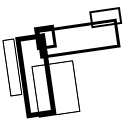

In [1933]:
x_train[9]

In [1938]:
train_array = []
for el in x_train:
    train_array.append(np.asarray(el))
train_array = np.asarray(train_array)/255.
y_train = np.asarray(y_train)
y_train = y_train.reshape(10000,1)

In [1939]:
print(train_array.shape)
print(y_train.shape)

(10000, 128, 128, 4)
(10000, 1)


In [1940]:
X = tf.placeholder(tf.float32, shape=[None,128,128,4])
Y = tf.placeholder(tf.float32, shape=[None,1])

#слои свертки и пулинга
conv1 = tf.layers.conv2d(inputs=X, filters=8, kernel_size=[2,2], padding="same", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
conv2 = tf.layers.conv2d(inputs=pool1,filters=4,kernel_size=[2,2],padding="same",activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#полносвязный слой
flattened = tf.contrib.layers.flatten(pool2)

w1 = tf.Variable(tf.random_normal(shape=[4096,1])) 
b1 = tf.Variable(tf.zeros(shape = [1]))
out = tf.add(tf.matmul(flattened,w1),b1)

#loss = tf.reduce_sum(tf.pow(out - Y, 2))/2*20
loss = tf.losses.mean_squared_error(labels=Y, predictions=out)
train_step = tf.train.AdamOptimizer(0.001).minimize(loss)#tf.train.GradientDescentOptimizer 

In [1941]:
flattened #размер вектора

<tf.Tensor 'Flatten_76/Reshape:0' shape=(?, 4096) dtype=float32>

In [1962]:
training_epochs = 100000

In [1963]:
#Инициализация
init = tf.global_variables_initializer()
#Обучение
sss = tf.Session()
sss.run(init)

for epoch in range(training_epochs):
    permutation=np.random.permutation(10000)
    permutation=permutation[0:20]
    batch=[train_array[permutation], y_train[permutation]]
    if epoch % 10000 == 0:
        #print(sss.run(w1, feed_dict={X:batch[0], Y: batch[1]}))
        print(sss.run(loss, feed_dict={X:batch[0], Y: batch[1]}))
        
    sss.run(train_step, feed_dict={X:batch[0], Y: batch[1]})

print("Optimization Finished!")

71.1731
0.00922785
0.0354189
0.0116758
0.00942143
0.013025
0.0146598
0.0150779
0.00964413
0.0125911
Optimization Finished!


# TEST

In [1966]:
for (l,m) in dataset_generator(10):
    x_test = l
    y_test= m

In [1967]:
test_array = []
for el in x_test:
    test_array.append(np.asarray(el))
test_array = np.asarray(test_array)/255.
y_test = np.asarray(y_test)
y_test = y_test.reshape(10,1)

In [1968]:
for i,k in enumerate(sss.run(out, feed_dict={X:test_array})):
    print(k, y_test[i])

[-7.3822875] [-7.46408077]
[ 3.94711781] [ 3.98439007]
[ 2.98931503] [ 3.03014516]
[-7.38166761] [-7.48834131]
[-7.36028004] [-7.41090688]
[ 8.92495251] [ 8.90838898]
[-2.12053275] [-2.19303047]
[-8.28981018] [-8.40237399]
[-5.80239296] [-5.84124736]
[ 0.43863463] [ 0.33312717]
